# Spacecraft Pose Estimation Model Example

In [1]:
%matplotlib inline
USE_GPU = True

In [2]:
from matplotlib import pyplot as plt
import numpy as np
from random import randint
from dataloader_utils import *
torch.manual_seed(42)
from PIL import Image, ImageDraw
from matplotlib import cm
import torchvision.transforms.functional as tF

if USE_GPU:
    print(torch.cuda.is_available())

True


## Testing dataloader

In [3]:
dataset_root_dir = '../../speed'
annotations_root_dir = '../annotations'

sample_transform = transforms.Compose([
    transforms.RandomRotation((-30, 30))
])

sample_dataset = SpeedDataset(speed_root=dataset_root_dir, annotations_root=annotations_root_dir, transform=None)

Bounding box [x_min, y_min, x_max, y_max]: [571.89217841 547.14270504 901.62193347 509.08239738]


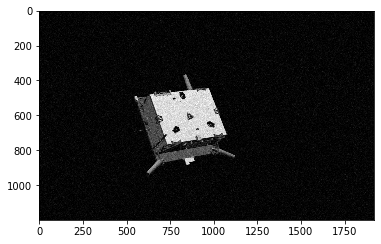

In [4]:
i = 895
img, label = sample_dataset[i]
plt.figure()
plt.imshow(img)
print("Bounding box [x_min, y_min, x_max, y_max]: {}".format(label[-4:]))

## Dataloading

In [5]:
class JointRescrop(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, img, target):
        target_q = target[:4]
        target_r = target[4:7]
        target_db = target[7:11] 
        target_bb = target[11:]

        sz = self.size[0]
        # Determine crop size that will still capture entire satellite
        x = [target_bb[i] for i in range(0, len(target_bb), 2)]
        y = [target_bb[i] for i in range(1, len(target_bb), 2)]
        xmin = min(x); xmax = max(x)
        ymin = min(y); ymax = max(y)
        fS = 1.75
        dx = xmax - xmin
        dy = ymax - ymin
        self.cropSize = int(fS * max(dx, dy))
        if self.cropSize > min(img.size):
            self.cropSize = min(img.size)
#         print("cropSize: ", cropSize)
        
        # Crop Image
        self.cx = sum(x)/len(x)
        self.cy = sum(y)/len(y)
        top = self.cy - self.cropSize/2
        left = self.cx - self.cropSize/2
        img = tF.crop(img, top, left, self.cropSize, self.cropSize)
        
        # Crop translation of points
        xtarget = [self.cropSize/2 + (i - self.cx) for i in x]
        ytarget = [self.cropSize/2 + (i - self.cy) for i in y]
        target_bb = [None]*(len(xtarget)+len(ytarget))
        target_bb[::2] = xtarget
        target_bb[1::2] = ytarget
        target_bb = np.array(target_bb)
        
        # Rescale to input size
        norm = img.size[1]
        img = tF.resize(img, sz)
        target_bb = [sz * i / norm for i in target_bb]
        target = np.concatenate((target_q, target_r, target_db, target_bb))

        return img, target

In [6]:
class JointToTensor(object):
    def __call__(self, img, target):
        return tF.to_tensor(img), torch.from_numpy(target)

In [7]:
class JointCompose(object):
    def __init__(self, transforms):
        """
        params: 
           transforms (list) : list of transforms
        """
        self.transforms = transforms

    # We override the __call__ function such that this class can be
    # called as a function i.e. JointCompose(transforms)(img, target)
    # Such classes are known as "functors"
    def __call__(self, img, target):
        """
        params:
            img (PIL.Image)    : input image
            target (PIL.Image) : ground truth label 
        """
        for t in self.transforms:
            img, target = t(img, target)
        return img, target

In [8]:
# Transforms
train_transform = JointCompose([
    JointRescrop((256,256)),
    JointToTensor(),
])

sanity_transform = JointCompose([
    JointRescrop((256,256)),
    JointToTensor(),
])

val_transform = JointCompose([
    JointRescrop((256,256)),
    JointToTensor(),
])

In [9]:
# Datasets
# NOTE: we don't have the labels for the test set, so we need to split the training set
training_dataset = SpeedDataset(
    split="train",
    split_index=100, # used to make a smaller training set for dev
    speed_root=dataset_root_dir,
    annotations_root=annotations_root_dir,        
    transform=train_transform
)

sanity_dataset = SpeedDataset(
    split="train",
    sanity_check=100,
    speed_root=dataset_root_dir,
    annotations_root=annotations_root_dir,        
    transform=sanity_transform
)

# val_dataset = SpeedDataset(
#     split="test",
#     speed_root=dataset_root_dir,
#     annotations_root=annotations_root_dir,        
#     transform=val_transform
# )

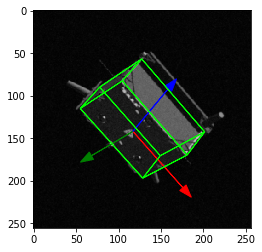

In [10]:
# TEST
sample, target = training_dataset[17]
image1, label1 = JointRescrop((256, 256))(tF.to_pil_image(sample), target.numpy())
training_dataset.visualize(image1, label1, factor=0.6, bbox=True)

In [11]:
(train_len, test_len) = (int(0.85*len(training_dataset)), int(0.15*len(training_dataset)))
assert train_len + test_len == len(training_dataset)
train_dataset, test_dataset = torch.utils.data.random_split(training_dataset, (train_len, test_len))

In [12]:
# Dataloading
WORKERS=6
train_loader = DataLoader(train_dataset, batch_size=16, num_workers=WORKERS, shuffle=False, drop_last=True) # NOTE: set shuffle to True!
sanity_loader = DataLoader(sanity_dataset, batch_size=1, num_workers=WORKERS, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=WORKERS, shuffle=False, drop_last=True)
# val_loader = DataLoader(val_dataset, batch_size=1, num_workers=WORKERS, shuffle=False)

## Existing network implementations (1/2)

The following is a pytorch implementation of [Deep3dBox](https://arxiv.org/pdf/1612.00496.pdf). Geometric constraints are used to solve for the translation (even though it is known to lock errors in if the 2D bounding box is inaccurate; see [MonoPSR](https://arxiv.org/pdf/1904.01690.pdf) or [Cascade geometric constratins](https://arxiv.org/pdf/1909.01867.pdf) for better alternatives). However, all these approaches focus on 3D bounding box estimation for cars and as a result, they can make pretty big assumptions about the orientation of the vehicle (i.e., roll and pitch equal to zero). These papers use multi-task CNN and multi-bin losses and would need to be extended to recover the full 6DOF.

In [13]:
# Pre-trained layers
DEEP3D = False
if DEEP3D:
    vgg = models.vgg19_bn(pretrained=True)

In [14]:
# Input size: 224x224 (imposed by vgg pretrained layers)

def OrientationLoss(orient_batch, orientGT_batch, confGT_batch):

    batch_size = orient_batch.size()[0]
    indexes = torch.max(confGT_batch, dim=1)[1]

    # extract just the important bin
    orientGT_batch = orientGT_batch[torch.arange(batch_size), indexes]
    orient_batch = orient_batch[torch.arange(batch_size), indexes]

    theta_diff = torch.atan2(orientGT_batch[:,1], orientGT_batch[:,0])
    estimated_theta_diff = torch.atan2(orient_batch[:,1], orient_batch[:,0])

    return -1 * torch.cos(theta_diff - estimated_theta_diff).mean()


class Deep3dBoxNet(nn.Module):
    def __init__(self, features=None, bins=2, w = 0.4):
        super(Deep3dBoxNet, self).__init__()
        self.bins = bins
        self.w = w
        self.features = features
        self.orientation = nn.Sequential(
                    nn.Linear(512 * 7 * 7, 256),
                    nn.ReLU(True),
                    nn.Dropout(),
                    nn.Linear(256, 256),
                    nn.ReLU(True),
                    nn.Dropout(),
                    nn.Linear(256, bins*2) # to get sin and cos
                )
        self.confidence = nn.Sequential(
                    nn.Linear(512 * 7 * 7, 256),
                    nn.ReLU(True),
                    nn.Dropout(),
                    nn.Linear(256, 256),
                    nn.ReLU(True),
                    nn.Dropout(),
                    nn.Linear(256, bins),
                    # nn.Softmax()
                    #nn.Sigmoid()
                )
        self.dimension = nn.Sequential(
                    nn.Linear(512 * 7 * 7, 512),
                    nn.ReLU(True),
                    nn.Dropout(),
                    nn.Linear(512, 512),
                    nn.ReLU(True),
                    nn.Dropout(),
                    nn.Linear(512, 3)
                )

    def forward(self, x):
        x = self.features(x) # 512 x 7 x 7
        x = x.view(-1, 512 * 7 * 7)
        orientation = self.orientation(x)
        orientation = orientation.view(-1, self.bins, 2)
        orientation = F.normalize(orientation, dim=2)
        confidence = self.confidence(x)
        dimension = self.dimension(x)
        return orientation, confidence, dimension

In [15]:
# Testing model with pretrained weights (epoch10) on Kitti
if DEEP3D:
    weight_filepath = '../weights/epoch_10.pkl'
    if USE_GPU == True:
        model = Deep3dBoxNet(features=vgg.features, bins=2).cuda()
    else:
        model = Deep3dBoxNet(features=vgg.features, bins=2)
    checkpoint = torch.load(weight_filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    # model.eval()

## Existing network implementations (2/2)
The following is an end-to-end implementation based on [USRO](https://arxiv.org/pdf/1907.04298.pdf) which seeks simplicity over efficiency. The team finished in 3rd place using resnet101 as their backbone. This implementation relies on resnet34 instead for computational reasons. Being more straightforward, this implementation is more suited to a study of domain adaptation.

In [16]:
# Pre-trained layers
resnet = models.resnet34(pretrained=True)

In [17]:
class URSONet(nn.Module):
    def __init__(self, criterion=None):
        super(URSONet, self).__init__()

        # Resnet backbone
        self.resnet = nn.Sequential(*list(resnet.children())[:-2]) 
        self.conv6 = nn.Conv2d(512, 1024, 3, 2)
        self.bn1 = nn.BatchNorm2d(1024)
        
        # Translation branch: t = [tx, ty, tz]
        # self.fc_t = nn.Linear(4*4*1024, 3)
        self.fc_t1 = nn.Linear(3*3*1024, 1024)
        self.fc_t2 = nn.Linear(1024, 3)

        # Attitude branch: q = [q0, q1, q2, q3]
        # NOTE: this assumes quaternions as attitude descriptors
        # self.fc_att = nn.Linear(4*4*1024, 4)
        self.fc_att1 = nn.Linear(3*3*1024, 1024)
        self.fc_att2 = nn.Linear(1024, 4)        
    
    def forward(self, input, gt=None):
        # Input size: 256x256
        # x = F.relu(self.resnet(input)) # NOTE: should we add activation after resnet?
        x = self.resnet(input)
        x = F.relu(self.bn1(self.conv6(x)))
        # Reshape after bottleneck
        x_t = x.view(-1, 3*3*1024)
        x_att = x.view(-1, 3*3*1024)

        # T regression
        x_t = F.relu(self.fc_t1(x_t))
        x_t = self.fc_t2(x_t)

        # q regression
        x_att = F.relu(self.fc_att1(x_att))
        x_att = self.fc_att2(x_att)

        return x_t, x_att

### Training

In [18]:
OVERFIT=False
TRAINING=True
if OVERFIT:
    overfit_net = URSONet()
    if USE_GPU:
        overfit_net = overfit_net.cuda()

In [19]:
def get_of_optimizer(net):
    # optimizer = torch.optim.Adam(net.parameters())
    optimizer = torch.optim.SGD(net.parameters(),
                                lr=0.0001,
                                weight_decay=0.0001,
                                momentum=0.9)
    return optimizer

In [20]:
def translation_loss(t_gt, t_pred):
    return torch.mean(torch.norm((t_gt - t_pred)/torch.norm(t_gt)))
    # return torch.mean(torch.cdist(t_gt, t_pred, p=2))


In [21]:
def attitude_loss(att, att_pred):
    # return torch.mean(torch.cdist(att, att_pred/torch.norm(att_pred), p=2))
    return torch.sum(torch.cdist(att, att_pred, p=2))

In [22]:
def train(train_loader, net, optimizer, loss_graph):
    epoch_loss = 0
    for i, data in enumerate(train_loader):
        inputs, target = data
        if USE_GPU:
            inputs = inputs.cuda()
            target = target.cuda()
        att_gt = target[:, :4].float()
        t_gt = target[:, 4:7].float()

        optimizer.zero_grad()
        t, att = net(inputs)

        L_t = translation_loss(t_gt, t)
        L_att = attitude_loss(att_gt, att)
        total_loss = L_t #+ L_att + 1.2*(torch.abs(1 - torch.norm(att)))
        loss_graph.append(total_loss.item())

        # loss_graph.append(total_loss.item())
        total_loss.backward()
        optimizer.step()

        epoch_loss += total_loss.item()
    return epoch_loss / len(train_loader)

In [23]:
EPOQUE = 120

if OVERFIT:
    # Training mode
    overfit_net.train()

    optimizer = get_of_optimizer(overfit_net)

    print("Starting Training...")

    loss_graph = []

    fig = plt.figure(figsize=(12,6))
    plt.subplots_adjust(bottom=0.2,right=0.85,top=0.95)
    ax = fig.add_subplot(1,1,1)


    for e in range(EPOQUE):
        loss = train(sanity_loader, overfit_net, optimizer, loss_graph)
        ax.clear()
        ax.set_xlabel('iterations')
        ax.set_ylabel('loss value')
        ax.set_title('Training loss curve for OVERFIT_NET')
        ax.plot(loss_graph, label='training loss')
        ax.legend(loc='upper right')
        fig.canvas.draw()
        print("Epoch: {} Loss: {}".format(e, loss))

### Evaluation

In [24]:
if OVERFIT:
    overfit_net.eval()
    img1, _ = sanity_dataset[0]
    label1 = sanity_dataset.labels[0]
    if USE_GPU:
        oimg1 = img1.cuda()
    t_out, att_out = overfit_net.forward(oimg1[None])
    t_out = t_out.detach().cpu().numpy()[0]
    att_out = att_out.detach().cpu().numpy()[0]
    img1 = img1.permute(1, 2, 0).numpy()
    plt.figure(0)
    sanity_dataset.visualize(img1, np.concatenate((np.array(label1['q']), np.array(label1['r']))), bbox=True)
    plt.figure(1)
    sanity_dataset.visualize(img1, np.concatenate((att_out, t_out)), bbox=True)


## Training
Training on entire dataset

In [25]:
def get_optimizer(net):
    # optimizer = torch.optim.Adam(net.parameters())
    optimizer = torch.optim.SGD(net.parameters(),
                                lr=0.0001,
                                weight_decay=0.0001,
                                momentum=0.9)
    return optimizer

Starting Training...
Epoch: 0 Loss: 0.99385746717453
Epoch: 1 Loss: 0.9906765937805175
Epoch: 2 Loss: 0.985633659362793
Epoch: 3 Loss: 0.9794461607933045
Epoch: 4 Loss: 0.9726035833358765
Epoch: 5 Loss: 0.9653981804847718
Epoch: 6 Loss: 0.9580030322074891
Epoch: 7 Loss: 0.9504683136940002
Epoch: 8 Loss: 0.9429006338119507
Epoch: 9 Loss: 0.935240113735199
Epoch: 10 Loss: 0.9275404930114746
Epoch: 11 Loss: 0.9197898507118225
Epoch: 12 Loss: 0.911983048915863
Epoch: 13 Loss: 0.9041254997253418
Epoch: 14 Loss: 0.8961831450462341
Epoch: 15 Loss: 0.8881478190422059
Epoch: 16 Loss: 0.8799931764602661
Epoch: 17 Loss: 0.8717060446739197
Epoch: 18 Loss: 0.8632998943328858
Epoch: 19 Loss: 0.854749345779419
Epoch: 20 Loss: 0.8460593581199646
Epoch: 21 Loss: 0.8371882319450379
Epoch: 22 Loss: 0.828148365020752
Epoch: 23 Loss: 0.8189105272293091
Epoch: 24 Loss: 0.8094919204711915
Epoch: 25 Loss: 0.7998750686645508
Epoch: 26 Loss: 0.7900346040725708
Epoch: 27 Loss: 0.7799969434738159
Epoch: 28 Loss: 

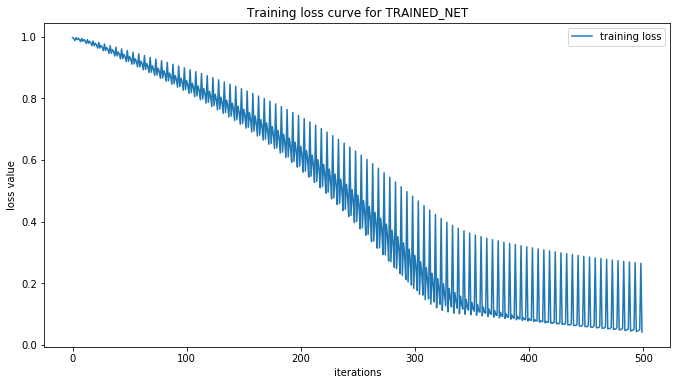

In [26]:
%%time
if TRAINING:
    EPOCH = 100
    trained_net = URSONet()
    if USE_GPU:
        trained_net = trained_net.cuda()
    optimizer = get_optimizer(trained_net)
    # switch to train mode
    trained_net.train()

    print("Starting Training...")

    loss_graph = []

    fig = plt.figure(figsize=(12,6))
    plt.subplots_adjust(bottom=0.2,right=0.85,top=0.95)
    ax = fig.add_subplot(1,1,1)


    for e in range(EPOCH):
        loss = train(train_loader, trained_net, optimizer, loss_graph)
        ax.clear()
        ax.set_xlabel('iterations')
        ax.set_ylabel('loss value')
        ax.set_title('Training loss curve for TRAINED_NET')
        ax.plot(loss_graph, label='training loss')
        ax.legend(loc='upper right')
        fig.canvas.draw()
        print("Epoch: {} Loss: {}".format(e, loss))

## Testing

In [27]:
def evaluate(val_loader, net):
    total_loss = 0
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            inputs, target = data

            if USE_GPU:
                inputs = inputs.cuda()
                target = target.cuda()

            att_gt = target[:, :4].float()
            t_gt = target[:, 4:7].float()

            t, att = net(inputs)

            L_t = translation_loss(t_gt, t)
            L_att = attitude_loss(att_gt, att)
            # print(1-torch.norm(att))
            total_loss += L_t + L_att + 1.2*(torch.abs(1 - torch.norm(att)))

    return total_loss / len(val_loader)

In [28]:
# switch to evaluation mode
# TODO: need more informative metric
trained_net.eval()
test_loss = evaluate(test_loader, trained_net)
print("Test error: {}".format(test_loss))

Test error: 2.1897799968719482


0.6456812607617515


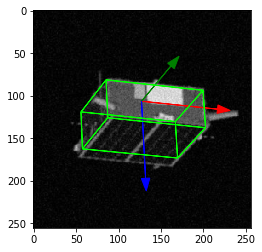

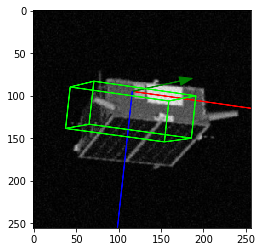

In [36]:
# Compare the learned pose to the ground-truth
%matplotlib inline
idx = 1
img1, label1 = test_dataset[idx]
# label1 = test_dataset.dataset.labels[idx]
if USE_GPU:
    img1 = img1.cuda()
t_out, att_out = trained_net.forward(img1[None])
t_out = t_out.detach().cpu().numpy()[0]
att_out = att_out.detach().cpu().numpy()[0]
img1 = img1.cpu()

size = (256, 256)
vectorScaleFactor = 4
image1, label1 = JointRescrop((256, 256))(tF.to_pil_image(img1), label1.numpy())
fig = plt.figure(0)
training_dataset.visualize(image1, label1, factor=0.6, bbox=True)

fig = plt.figure(1)
test_dataset.dataset.visualize(image1, np.concatenate((att_out, t_out)), bbox=True)
print(np.linalg.norm(t_out - label1[4:7]))


In [30]:
t_out

array([ 0.0779357, -0.0464721, 14.639323 ], dtype=float32)

In [31]:
label1[4:7]

array([ 0.14829 ,  0.023222, 15.277365])